# Data exploration and preprocessing

- In this notebook, we load in the MRI scans and their segmentations, build a Dataset object for the train, eval and test set.
- Then we check some basic stats of the datasets and visualise a few scans.
- Finally, we carry out our preprocessing steps and save the train, eval and test datasets.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import copy
import logging
from glob import glob
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/amos/3D_UNet_Invivo/')

from src.data_utils import Dataset

# get TF logger - set it to info for more tracking process
log = logging.getLogger('tensorflow')
log.setLevel(logging.WARNING)

## Create train and test datasets invivo

Find all the raw data files and build train and test Dataset objects from the patients' scans. 

In [3]:
# training files
_all_files = glob('../data/raw/train/**/*mask2_*.dcm', recursive=True)
#_all_files = glob('../data/raw/train/**/*RIGHT.dcm', recursive=True)
train_scan_files = [s.replace("_mask2_", "_t1_") for s in _all_files]
train_seg_files = [s.replace("_t1_", "_mask2_") for s in train_scan_files]
#train_scan_files = [s for s in train_scan_files if not 'plaque' in s]
#train_seg_files = [s for s in train_seg_files if not 'plaque' in s]


# evaluation files
_all_files2 = glob('../data/raw/eval/**/*mask2_*.dcm', recursive=True)
eval_scan_files = [s.replace("_mask2_", "_t1_") for s in _all_files2]
eval_seg_files = [s.replace("_t1_", "_mask2_") for s in eval_scan_files]
#eval_scan_files = [s for s in eval_scan_files if not 'plaque' in s]
#eval_seg_files = [s for s in eval_seg_files if not 'plaque' in s]




# testing files
_all_files3 = glob('../data/raw/test/**/*mask2_*.dcm', recursive=True)
test_scan_files = [s.replace("_mask2_", "_t1_") for s in _all_files3]
test_seg_files = [s.replace("_t1_", "_mask2_") for s in test_scan_files]
#test_scan_files = [s for s in test_scan_files if not 'plaque' in s]
#test_seg_files = [s for s in test_seg_files if not 'plaque' in s]




# build datasets from file paths
train_dataset = Dataset(scan_files=train_scan_files, seg_files=train_seg_files)
eval_dataset = Dataset(scan_files=eval_scan_files, seg_files=eval_seg_files)
test_dataset = Dataset(scan_files=test_scan_files, seg_files=test_seg_files)





In [4]:
print(eval_seg_files[0])
print('-----------------')
print(eval_scan_files[0])

../data/raw/eval/JG049_mask2_2_LEFT.dcm
-----------------
../data/raw/eval/JG049_t1_2_LEFT.dcm


In [5]:
print(test_seg_files[0])
print('-----------------')
print(test_scan_files[0])

../data/raw/test/TS039_mask2_0_RIGHT.dcm
-----------------
../data/raw/test/TS039_t1_0_RIGHT.dcm


In [6]:
print(train_seg_files[0])
print('-----------------')
print(train_scan_files[0])

../data/raw/train/MH040_mask2_7_LEFT.dcm
-----------------
../data/raw/train/MH040_t1_7_LEFT.dcm


In [7]:
print(len(train_seg_files))
print('-----------------')
print(len(train_scan_files))


1500
-----------------
1500


In [8]:
print(len(eval_seg_files))
print('-----------------')
print(len(eval_scan_files))

343
-----------------
343


In [9]:
print(len(test_seg_files))
print('-----------------')
print(len(test_scan_files))

82
-----------------
82


In [10]:
print('Total number of T1s: ' +str(len(train_scan_files) + len(eval_scan_files) + len(test_scan_files)))
print('--------------------------')
print('Total number of Masks: ' +str(len(train_seg_files) + len(eval_seg_files) + len(test_seg_files)))
print('--------------------------')


Total number of T1s: 1925
--------------------------
Total number of Masks: 1925
--------------------------


## Check basic stats
Check number of patients in train and test datasets.

In [11]:
train_n = len(train_dataset.patient_ids)
eval_n = len(eval_dataset.patient_ids)
test_n = len(test_dataset.patient_ids)

train_scan_nums = [p.scans[0].shape[0] for p in train_dataset.patients.values()]
eval_scan_nums = [p.scans[0].shape[0] for p in eval_dataset.patients.values()]
test_scan_nums = [p.scans[0].shape[0] for p in test_dataset.patients.values()]

print('Number of patients in train dataset: %d' % train_n)
print('Number of patients in eval dataset: %d' % eval_n)
print('Number of patients in test dataset: %d' % test_n)
print('----------------------------------------------')
print('Number of scans in train dataset: %d' % sum(train_scan_nums))
print('Number of scans in eval dataset: %d' % sum(eval_scan_nums))
print('Number of scans in test dataset: %d' % sum(test_scan_nums))

Number of patients in train dataset: 41
Number of patients in eval dataset: 15
Number of patients in test dataset: 5
----------------------------------------------
Number of scans in train dataset: 10496
Number of scans in eval dataset: 3840
Number of scans in test dataset: 1280


Check distribution of number of scans in train and test datasets.
- They both seem bi-modal with roughly the same peaks. 

(array([0., 0., 0., 0., 0., 5., 0., 0., 0., 0.]),
 array([255.5, 255.6, 255.7, 255.8, 255.9, 256. , 256.1, 256.2, 256.3,
        256.4, 256.5]),
 <a list of 10 Patch objects>)

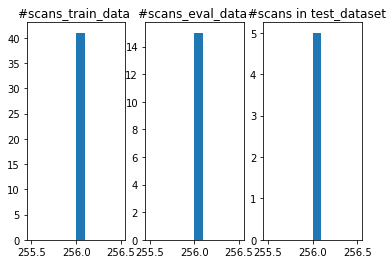

In [12]:
fig, ax = plt.subplots(1, 3)
ax[0].set_title('#scans_train_data ')
ax[0].hist(train_scan_nums, bins=10)

ax[1].set_title('#scans_eval_data ')
ax[1].hist(eval_scan_nums, bins=10)

ax[2].set_title('  #scans in test_dataset')
ax[2].hist(test_scan_nums, bins=10)

Make sure that none of the patients have scans from mixed manufacturers and with mixed slice thickness.

In [13]:
# # extract manufacturer and thickness sets from each patient
# train_manufacturers = [p.manufacturers for p in train_dataset.patients.values()]
# train_thicknesses = [p.thicknesses for p in train_dataset.patients.values()]

# eval_manufacturers = [p.manufacturers for p in eval_dataset.patients.values()]
# eval_thicknesses = [p.thicknesses for p in eval_dataset.patients.values()]

# test_manufacturers = [p.manufacturers for p in test_dataset.patients.values()]
# test_thicknesses = [p.thicknesses for p in test_dataset.patients.values()]

# # check if any patient has slices from two different manufacturers or thicknesses - NO
# for m in train_manufacturers + test_manufacturers:
#     assert len(m) == 1
    
# for n in eval_manufacturers + eval_manufacturers:
#     assert len(n) == 1

# for t in train_thicknesses + test_thicknesses:
#     assert len(t) == 1

### Create summary table 

Collate all information into a pandas DataFrame from the datasets so we can analyse it easily later.

In [14]:
# # collapse all list of sets to simple list
# train_manufacturers = [list(i)[0] for i in train_manufacturers]
# train_thicknesses = [list(i)[0] for i in train_thicknesses]

# eval_manufacturers = [list(i)[0] for i in eval_manufacturers]
# eval_thicknesses = [list(i)[0] for i in eval_thicknesses]

# test_manufacturers = [list(i)[0] for i in test_manufacturers]
# test_thicknesses = [list(i)[0] for i in test_thicknesses]

# # extract scan width, height and max value
# train_widths = [p.scans.shape[1] for p in train_dataset.patients.values()]
# train_heights = [p.scans.shape[2] for p in train_dataset.patients.values()]
# train_max = [p.scans.max() for p in train_dataset.patients.values()]

# eval_widths = [p.scans.shape[1] for p in eval_dataset.patients.values()]
# eval_heights = [p.scans.shape[2] for p in eval_dataset.patients.values()]
# eval_max = [p.scans.max() for p in eval_dataset.patients.values()]


# test_widths = [p.scans.shape[1] for p in test_dataset.patients.values()]
# test_heights = [p.scans.shape[2] for p in test_dataset.patients.values()]
# test_max = [p.scans.max() for p in test_dataset.patients.values()]

# # calculate contingency table from them
# df_summary = pd.DataFrame(
#     list(
#         zip(
#             train_dataset.patient_ids +  eval_dataset.patient_ids + test_dataset.patient_ids,
#             train_manufacturers + eval_manufacturers + test_manufacturers,
#             train_thicknesses + eval_thicknesses + test_thicknesses,
#             train_widths + eval_widths + test_widths,
#             train_heights + eval_heights + test_heights,
#             train_max + eval_max + test_max,
#             train_scan_nums + eval_scan_nums + test_scan_nums,
#             ['train'] * train_n + ['eval'] * eval_n + ['test'] * test_n
#         )
#     ), 
#     columns = ['patient_id', 'manufacturer', 'thickness', 
#                'width', 'heigth', 'max_val', 'scan_num', 'dataset']
# )

- Looks like the test and train datasets have been properly stratified with respect to manufacturer, i.e. half of the sample are from Siemens and half of them are from Philips.
- However, the test dataset doesn't have slices of 4mm thickness.

In [15]:
# df_summary.drop(
#     ['width', 'heigth', 'scan_num', 'max_val'], axis=1
# ).groupby(
#     ['dataset', 'manufacturer', 'thickness']
# ).count()

- Philips is the higher resolution machine, all scans are rectangular.

In [16]:
# df_summary.drop(
#     ['thickness', 'max_val', 'scan_num'], axis=1
# ).groupby(
#     ['dataset', 'manufacturer', 'width', 'heigth']
# ).count()

- There's a large variation in the scans' maximum values and there are some clear outliers too (Siemens scan with max=65283, coming from the 18th scan of patient Prostate3T-01-0018)

In [17]:
# df_summary.drop(
#     ['thickness', 'patient_id', 'scan_num'], axis=1
# ).groupby(
#     ['dataset', 'manufacturer', 'width', 'heigth']
# ).agg(['min', 'max', 'mean'])

- Here's the reason for those bi-modal histograms above, Philips mave higher number of scans on average.

In [18]:
# df_summary.drop(
#     ['thickness', 'max_val', 'width', 'heigth', 'patient_id'], axis=1
# ).groupby(
#     ['dataset', 'manufacturer']
# ).agg(['min', 'max', 'median'])

## Calculate class frequency

The 15 classes are imbalanced, calculate their frequency in the data. This will inform our weighting scheme that we use with the loss function at training time.

In [19]:
class_freq = np.zeros(3)
for i in range(len(train_dataset.patients.keys())):
    patient_id = train_dataset.patient_ids[i]
    
    #TODO: cross check this result
    segList = train_dataset.patients[patient_id].segs
    for j, seg in enumerate(segList):
        print(seg.shape)


        class0  = np.count_nonzero(np.where(seg == 0))
        class1  = np.count_nonzero(np.where(seg == 1))
        class2  = np.count_nonzero(np.where(seg == 2))

        print('class0: ' + str(class0))
        print('.......................')
        print('class1: ' + str(class1))
        print('.......................')
        print('class2: ' + str(class2))

        class_freq += np.array([class0, class1, class2])
    
    
class_freq = class_freq / class_freq.sum()
#print(class_freq)  
inv_class_freq = []
for i in range(3):
    if class_freq[i]==0:
        inv_class_freq.append(0)
    else:
        inv_class_freq.append(1/class_freq[i])
#print(inv_class_freq)
norm_inv_class_freq = inv_class_freq / np.array(inv_class_freq).sum()
norm_inv_class_freq


(256, 256)
class0: 128674
.......................
class1: 1062
.......................
class2: 824
(256, 256)
class0: 128674
.......................
class1: 1062
.......................
class2: 824
(256, 256)
class0: 128674
.......................
class1: 1062
.......................
class2: 824
(256, 256)
class0: 128674
.......................
class1: 1062
.......................
class2: 824
(256, 256)
class0: 128674
.......................
class1: 1062
.......................
class2: 824
(256, 256)
class0: 128674
.......................
class1: 1062
.......................
class2: 824
(256, 256)
class0: 128674
.......................
class1: 1062
.......................
class2: 824
(256, 256)
class0: 128674
.......................
class1: 1062
.......................
class2: 824
(256, 256)
class0: 128674
.......................
class1: 1062
.......................
class2: 824
(256, 256)
class0: 124308
.......................
class1: 3848
.......................
class2: 2404
(256, 256

class0: 128472
.......................
class1: 994
.......................
class2: 1094
(256, 256)
class0: 128472
.......................
class1: 994
.......................
class2: 1094
(256, 256)
class0: 128472
.......................
class1: 994
.......................
class2: 1094
(256, 256)
class0: 128472
.......................
class1: 994
.......................
class2: 1094
(256, 256)
class0: 128472
.......................
class1: 994
.......................
class2: 1094
(256, 256)
class0: 128472
.......................
class1: 994
.......................
class2: 1094
(256, 256)
class0: 128472
.......................
class1: 994
.......................
class2: 1094
(256, 256)
class0: 128472
.......................
class1: 994
.......................
class2: 1094
(256, 256)
class0: 128472
.......................
class1: 994
.......................
class2: 1094
(256, 256)
class0: 128414
.......................
class1: 1308
.......................
class2: 838
(256, 256)
class0: 12

class0: 127094
.......................
class1: 2188
.......................
class2: 1278
(256, 256)
class0: 127094
.......................
class1: 2188
.......................
class2: 1278
(256, 256)
class0: 129272
.......................
class1: 672
.......................
class2: 616
(256, 256)
class0: 129272
.......................
class1: 672
.......................
class2: 616
(256, 256)
class0: 129272
.......................
class1: 672
.......................
class2: 616
(256, 256)
class0: 129272
.......................
class1: 672
.......................
class2: 616
(256, 256)
class0: 129272
.......................
class1: 672
.......................
class2: 616
(256, 256)
class0: 129272
.......................
class1: 672
.......................
class2: 616
(256, 256)
class0: 129272
.......................
class1: 672
.......................
class2: 616
(256, 256)
class0: 129272
.......................
class1: 672
.......................
class2: 616
(256, 256)
class0: 129272
.

class0: 127394
.......................
class1: 1572
.......................
class2: 1594
(256, 256)
class0: 127394
.......................
class1: 1572
.......................
class2: 1594
(256, 256)
class0: 127936
.......................
class1: 1228
.......................
class2: 1396
(256, 256)
class0: 127936
.......................
class1: 1228
.......................
class2: 1396
(256, 256)
class0: 127936
.......................
class1: 1228
.......................
class2: 1396
(256, 256)
class0: 127936
.......................
class1: 1228
.......................
class2: 1396
(256, 256)
class0: 127936
.......................
class1: 1228
.......................
class2: 1396
(256, 256)
class0: 127936
.......................
class1: 1228
.......................
class2: 1396
(256, 256)
class0: 127936
.......................
class1: 1228
.......................
class2: 1396
(256, 256)
class0: 127936
.......................
class1: 1228
.......................
class2: 1396
(256, 256)


class0: 129642
.......................
class1: 478
.......................
class2: 440
(256, 256)
class0: 129642
.......................
class1: 478
.......................
class2: 440
(256, 256)
class0: 129642
.......................
class1: 478
.......................
class2: 440
(256, 256)
class0: 129642
.......................
class1: 478
.......................
class2: 440
(256, 256)
class0: 129642
.......................
class1: 478
.......................
class2: 440
(256, 256)
class0: 129642
.......................
class1: 478
.......................
class2: 440
(256, 256)
class0: 129642
.......................
class1: 478
.......................
class2: 440
(256, 256)
class0: 129642
.......................
class1: 478
.......................
class2: 440
(256, 256)
class0: 129642
.......................
class1: 478
.......................
class2: 440
(256, 256)
class0: 128660
.......................
class1: 866
.......................
class2: 1034
(256, 256)
class0: 128660
....

class0: 126570
.......................
class1: 2824
.......................
class2: 1166
(256, 256)
class0: 126570
.......................
class1: 2824
.......................
class2: 1166
(256, 256)
class0: 126570
.......................
class1: 2824
.......................
class2: 1166
(256, 256)
class0: 126570
.......................
class1: 2824
.......................
class2: 1166
(256, 256)
class0: 126570
.......................
class1: 2824
.......................
class2: 1166
(256, 256)
class0: 126570
.......................
class1: 2824
.......................
class2: 1166
(256, 256)
class0: 128758
.......................
class1: 998
.......................
class2: 804
(256, 256)
class0: 128758
.......................
class1: 998
.......................
class2: 804
(256, 256)
class0: 128758
.......................
class1: 998
.......................
class2: 804
(256, 256)
class0: 128758
.......................
class1: 998
.......................
class2: 804
(256, 256)
class0: 

class0: 125044
.......................
class1: 2332
.......................
class2: 3184
(256, 256)
class0: 125044
.......................
class1: 2332
.......................
class2: 3184
(256, 256)
class0: 125044
.......................
class1: 2332
.......................
class2: 3184
(256, 256)
class0: 125044
.......................
class1: 2332
.......................
class2: 3184
(256, 256)
class0: 125044
.......................
class1: 2332
.......................
class2: 3184
(256, 256)
class0: 125044
.......................
class1: 2332
.......................
class2: 3184
(256, 256)
class0: 125044
.......................
class1: 2332
.......................
class2: 3184
(256, 256)
class0: 125044
.......................
class1: 2332
.......................
class2: 3184
(256, 256)
class0: 127950
.......................
class1: 1330
.......................
class2: 1280
(256, 256)
class0: 127950
.......................
class1: 1330
.......................
class2: 1280
(256, 256)


class0: 123120
.......................
class1: 2694
.......................
class2: 4746
(256, 256)
class0: 123120
.......................
class1: 2694
.......................
class2: 4746
(256, 256)
class0: 123120
.......................
class1: 2694
.......................
class2: 4746
(256, 256)
class0: 123120
.......................
class1: 2694
.......................
class2: 4746
(256, 256)
class0: 123120
.......................
class1: 2694
.......................
class2: 4746
(256, 256)
class0: 123120
.......................
class1: 2694
.......................
class2: 4746
(256, 256)
class0: 126418
.......................
class1: 2728
.......................
class2: 1414
(256, 256)
class0: 126418
.......................
class1: 2728
.......................
class2: 1414
(256, 256)
class0: 126418
.......................
class1: 2728
.......................
class2: 1414
(256, 256)
class0: 126418
.......................
class1: 2728
.......................
class2: 1414
(256, 256)


class0: 125504
.......................
class1: 3048
.......................
class2: 2008
(256, 256)
class0: 125504
.......................
class1: 3048
.......................
class2: 2008
(256, 256)
class0: 125504
.......................
class1: 3048
.......................
class2: 2008
(256, 256)
class0: 125504
.......................
class1: 3048
.......................
class2: 2008
(256, 256)
class0: 125504
.......................
class1: 3048
.......................
class2: 2008
(256, 256)
class0: 125504
.......................
class1: 3048
.......................
class2: 2008
(256, 256)
class0: 125504
.......................
class1: 3048
.......................
class2: 2008
(256, 256)
class0: 128616
.......................
class1: 1094
.......................
class2: 850
(256, 256)
class0: 128616
.......................
class1: 1094
.......................
class2: 850
(256, 256)
class0: 128616
.......................
class1: 1094
.......................
class2: 850
(256, 256)
cla

class0: 127320
.......................
class1: 1636
.......................
class2: 1604
(256, 256)
class0: 127320
.......................
class1: 1636
.......................
class2: 1604
(256, 256)
class0: 127320
.......................
class1: 1636
.......................
class2: 1604
(256, 256)
class0: 127320
.......................
class1: 1636
.......................
class2: 1604
(256, 256)
class0: 127320
.......................
class1: 1636
.......................
class2: 1604
(256, 256)
class0: 127320
.......................
class1: 1636
.......................
class2: 1604
(256, 256)
class0: 127320
.......................
class1: 1636
.......................
class2: 1604
(256, 256)
class0: 127320
.......................
class1: 1636
.......................
class2: 1604
(256, 256)
class0: 128762
.......................
class1: 976
.......................
class2: 822
(256, 256)
class0: 128762
.......................
class1: 976
.......................
class2: 822
(256, 256)
clas

class0: 128038
.......................
class1: 1448
.......................
class2: 1074
(256, 256)
class0: 128038
.......................
class1: 1448
.......................
class2: 1074
(256, 256)
class0: 128038
.......................
class1: 1448
.......................
class2: 1074
(256, 256)
class0: 128038
.......................
class1: 1448
.......................
class2: 1074
(256, 256)
class0: 128038
.......................
class1: 1448
.......................
class2: 1074
(256, 256)
class0: 128038
.......................
class1: 1448
.......................
class2: 1074
(256, 256)
class0: 128038
.......................
class1: 1448
.......................
class2: 1074
(256, 256)
class0: 125428
.......................
class1: 3176
.......................
class2: 1956
(256, 256)
class0: 125428
.......................
class1: 3176
.......................
class2: 1956
(256, 256)
class0: 125428
.......................
class1: 3176
.......................
class2: 1956
(256, 256)


class0: 128486
.......................
class1: 1512
.......................
class2: 562
(256, 256)
class0: 128486
.......................
class1: 1512
.......................
class2: 562
(256, 256)
class0: 128486
.......................
class1: 1512
.......................
class2: 562
(256, 256)
class0: 128486
.......................
class1: 1512
.......................
class2: 562
(256, 256)
class0: 128486
.......................
class1: 1512
.......................
class2: 562
(256, 256)
class0: 128486
.......................
class1: 1512
.......................
class2: 562
(256, 256)
class0: 128486
.......................
class1: 1512
.......................
class2: 562
(256, 256)
class0: 128486
.......................
class1: 1512
.......................
class2: 562
(256, 256)
class0: 128486
.......................
class1: 1512
.......................
class2: 562
(256, 256)
class0: 123050
.......................
class1: 3826
.......................
class2: 3684
(256, 256)
class0: 1

class0: 126658
.......................
class1: 1816
.......................
class2: 2086
(256, 256)
class0: 126658
.......................
class1: 1816
.......................
class2: 2086
(256, 256)
class0: 126658
.......................
class1: 1816
.......................
class2: 2086
(256, 256)
class0: 126658
.......................
class1: 1816
.......................
class2: 2086
(256, 256)
class0: 126658
.......................
class1: 1816
.......................
class2: 2086
(256, 256)
class0: 126658
.......................
class1: 1816
.......................
class2: 2086
(256, 256)
class0: 126658
.......................
class1: 1816
.......................
class2: 2086
(256, 256)
class0: 128118
.......................
class1: 1560
.......................
class2: 882
(256, 256)
class0: 128118
.......................
class1: 1560
.......................
class2: 882
(256, 256)
class0: 128118
.......................
class1: 1560
.......................
class2: 882
(256, 256)
cla

class0: 126570
.......................
class1: 1654
.......................
class2: 2336
(256, 256)
class0: 126570
.......................
class1: 1654
.......................
class2: 2336
(256, 256)
class0: 126570
.......................
class1: 1654
.......................
class2: 2336
(256, 256)
class0: 126570
.......................
class1: 1654
.......................
class2: 2336
(256, 256)
class0: 129174
.......................
class1: 720
.......................
class2: 666
(256, 256)
class0: 129174
.......................
class1: 720
.......................
class2: 666
(256, 256)
class0: 129174
.......................
class1: 720
.......................
class2: 666
(256, 256)
class0: 129174
.......................
class1: 720
.......................
class2: 666
(256, 256)
class0: 129174
.......................
class1: 720
.......................
class2: 666
(256, 256)
class0: 129174
.......................
class1: 720
.......................
class2: 666
(256, 256)
class0: 1291

class0: 129176
.......................
class1: 684
.......................
class2: 700
(256, 256)
class0: 129176
.......................
class1: 684
.......................
class2: 700
(256, 256)
class0: 128170
.......................
class1: 1388
.......................
class2: 1002
(256, 256)
class0: 128170
.......................
class1: 1388
.......................
class2: 1002
(256, 256)
class0: 128170
.......................
class1: 1388
.......................
class2: 1002
(256, 256)
class0: 128170
.......................
class1: 1388
.......................
class2: 1002
(256, 256)
class0: 128170
.......................
class1: 1388
.......................
class2: 1002
(256, 256)
class0: 128170
.......................
class1: 1388
.......................
class2: 1002
(256, 256)
class0: 128170
.......................
class1: 1388
.......................
class2: 1002
(256, 256)
class0: 128170
.......................
class1: 1388
.......................
class2: 1002
(256, 256)
clas

(256, 256)
class0: 127424
.......................
class1: 1776
.......................
class2: 1360
(256, 256)
class0: 127424
.......................
class1: 1776
.......................
class2: 1360
(256, 256)
class0: 128738
.......................
class1: 952
.......................
class2: 870
(256, 256)
class0: 128738
.......................
class1: 952
.......................
class2: 870
(256, 256)
class0: 128738
.......................
class1: 952
.......................
class2: 870
(256, 256)
class0: 128738
.......................
class1: 952
.......................
class2: 870
(256, 256)
class0: 128738
.......................
class1: 952
.......................
class2: 870
(256, 256)
class0: 128738
.......................
class1: 952
.......................
class2: 870
(256, 256)
class0: 128738
.......................
class1: 952
.......................
class2: 870
(256, 256)
class0: 128738
.......................
class1: 952
.......................
class2: 870
(256, 256)
class

class0: 126442
.......................
class1: 1888
.......................
class2: 2230
(256, 256)
class0: 126442
.......................
class1: 1888
.......................
class2: 2230
(256, 256)
class0: 128278
.......................
class1: 1222
.......................
class2: 1060
(256, 256)
class0: 128278
.......................
class1: 1222
.......................
class2: 1060
(256, 256)
class0: 128278
.......................
class1: 1222
.......................
class2: 1060
(256, 256)
class0: 128278
.......................
class1: 1222
.......................
class2: 1060
(256, 256)
class0: 128278
.......................
class1: 1222
.......................
class2: 1060
(256, 256)
class0: 128278
.......................
class1: 1222
.......................
class2: 1060
(256, 256)
class0: 128278
.......................
class1: 1222
.......................
class2: 1060
(256, 256)
class0: 128278
.......................
class1: 1222
.......................
class2: 1060
(256, 256)


class0: 125900
.......................
class1: 3734
.......................
class2: 926
(256, 256)
class0: 125900
.......................
class1: 3734
.......................
class2: 926
(256, 256)
class0: 128300
.......................
class1: 1188
.......................
class2: 1072
(256, 256)
class0: 128300
.......................
class1: 1188
.......................
class2: 1072
(256, 256)
class0: 128300
.......................
class1: 1188
.......................
class2: 1072
(256, 256)
class0: 128300
.......................
class1: 1188
.......................
class2: 1072
(256, 256)
class0: 128300
.......................
class1: 1188
.......................
class2: 1072
(256, 256)
class0: 128300
.......................
class1: 1188
.......................
class2: 1072
(256, 256)
class0: 128300
.......................
class1: 1188
.......................
class2: 1072
(256, 256)
class0: 128300
.......................
class1: 1188
.......................
class2: 1072
(256, 256)
cl

class0: 127552
.......................
class1: 1346
.......................
class2: 1662
(256, 256)
class0: 127552
.......................
class1: 1346
.......................
class2: 1662
(256, 256)
class0: 128540
.......................
class1: 900
.......................
class2: 1120
(256, 256)
class0: 128540
.......................
class1: 900
.......................
class2: 1120
(256, 256)
class0: 128540
.......................
class1: 900
.......................
class2: 1120
(256, 256)
class0: 128540
.......................
class1: 900
.......................
class2: 1120
(256, 256)
class0: 128540
.......................
class1: 900
.......................
class2: 1120
(256, 256)
class0: 128540
.......................
class1: 900
.......................
class2: 1120
(256, 256)
class0: 128540
.......................
class1: 900
.......................
class2: 1120
(256, 256)
class0: 128540
.......................
class1: 900
.......................
class2: 1120
(256, 256)
class0: 

class0: 127080
.......................
class1: 1740
.......................
class2: 1740
(256, 256)
class0: 127080
.......................
class1: 1740
.......................
class2: 1740
(256, 256)
class0: 127080
.......................
class1: 1740
.......................
class2: 1740
(256, 256)
class0: 127080
.......................
class1: 1740
.......................
class2: 1740
(256, 256)
class0: 128840
.......................
class1: 986
.......................
class2: 734
(256, 256)
class0: 128840
.......................
class1: 986
.......................
class2: 734
(256, 256)
class0: 128840
.......................
class1: 986
.......................
class2: 734
(256, 256)
class0: 128840
.......................
class1: 986
.......................
class2: 734
(256, 256)
class0: 128840
.......................
class1: 986
.......................
class2: 734
(256, 256)
class0: 128840
.......................
class1: 986
.......................
class2: 734
(256, 256)
class0: 1288

class0: 127728
.......................
class1: 1356
.......................
class2: 1476
(256, 256)
class0: 127728
.......................
class1: 1356
.......................
class2: 1476
(256, 256)
class0: 125798
.......................
class1: 3168
.......................
class2: 1594
(256, 256)
class0: 125798
.......................
class1: 3168
.......................
class2: 1594
(256, 256)
class0: 125798
.......................
class1: 3168
.......................
class2: 1594
(256, 256)
class0: 125798
.......................
class1: 3168
.......................
class2: 1594
(256, 256)
class0: 125798
.......................
class1: 3168
.......................
class2: 1594
(256, 256)
class0: 125798
.......................
class1: 3168
.......................
class2: 1594
(256, 256)
class0: 125798
.......................
class1: 3168
.......................
class2: 1594
(256, 256)
class0: 125798
.......................
class1: 3168
.......................
class2: 1594
(256, 256)


class0: 126124
.......................
class1: 1832
.......................
class2: 2604
(256, 256)
class0: 126124
.......................
class1: 1832
.......................
class2: 2604
(256, 256)
class0: 126124
.......................
class1: 1832
.......................
class2: 2604
(256, 256)
class0: 126124
.......................
class1: 1832
.......................
class2: 2604
(256, 256)
class0: 126124
.......................
class1: 1832
.......................
class2: 2604
(256, 256)
class0: 126124
.......................
class1: 1832
.......................
class2: 2604
(256, 256)
class0: 126124
.......................
class1: 1832
.......................
class2: 2604
(256, 256)
class0: 126124
.......................
class1: 1832
.......................
class2: 2604
(256, 256)
class0: 126124
.......................
class1: 1832
.......................
class2: 2604
(256, 256)
class0: 127616
.......................
class1: 1670
.......................
class2: 1274
(256, 256)


class0: 124522
.......................
class1: 2676
.......................
class2: 3362
(256, 256)
class0: 124522
.......................
class1: 2676
.......................
class2: 3362
(256, 256)
class0: 124522
.......................
class1: 2676
.......................
class2: 3362
(256, 256)
class0: 124522
.......................
class1: 2676
.......................
class2: 3362
(256, 256)
class0: 124522
.......................
class1: 2676
.......................
class2: 3362
(256, 256)
class0: 124522
.......................
class1: 2676
.......................
class2: 3362
(256, 256)
class0: 124522
.......................
class1: 2676
.......................
class2: 3362
(256, 256)
class0: 129092
.......................
class1: 896
.......................
class2: 572
(256, 256)
class0: 129092
.......................
class1: 896
.......................
class2: 572
(256, 256)
class0: 129092
.......................
class1: 896
.......................
class2: 572
(256, 256)
class0

class0: 129282
.......................
class1: 674
.......................
class2: 604
(256, 256)
class0: 129282
.......................
class1: 674
.......................
class2: 604
(256, 256)
class0: 129282
.......................
class1: 674
.......................
class2: 604
(256, 256)
class0: 129282
.......................
class1: 674
.......................
class2: 604
(256, 256)
class0: 129282
.......................
class1: 674
.......................
class2: 604
(256, 256)
class0: 129282
.......................
class1: 674
.......................
class2: 604
(256, 256)
class0: 129282
.......................
class1: 674
.......................
class2: 604
(256, 256)
class0: 127656
.......................
class1: 1606
.......................
class2: 1298
(256, 256)
class0: 127656
.......................
class1: 1606
.......................
class2: 1298
(256, 256)
class0: 127656
.......................
class1: 1606
.......................
class2: 1298
(256, 256)
class0: 127656

class0: 125682
.......................
class1: 2672
.......................
class2: 2206
(256, 256)
class0: 125682
.......................
class1: 2672
.......................
class2: 2206
(256, 256)
class0: 125682
.......................
class1: 2672
.......................
class2: 2206
(256, 256)
class0: 125682
.......................
class1: 2672
.......................
class2: 2206
(256, 256)
class0: 125682
.......................
class1: 2672
.......................
class2: 2206
(256, 256)
class0: 125682
.......................
class1: 2672
.......................
class2: 2206
(256, 256)
class0: 128220
.......................
class1: 1140
.......................
class2: 1200
(256, 256)
class0: 128220
.......................
class1: 1140
.......................
class2: 1200
(256, 256)
class0: 128220
.......................
class1: 1140
.......................
class2: 1200
(256, 256)
class0: 128220
.......................
class1: 1140
.......................
class2: 1200
(256, 256)


class0: 127684
.......................
class1: 1578
.......................
class2: 1298
(256, 256)
class0: 127684
.......................
class1: 1578
.......................
class2: 1298
(256, 256)
class0: 127684
.......................
class1: 1578
.......................
class2: 1298
(256, 256)
class0: 125554
.......................
class1: 2400
.......................
class2: 2606
(256, 256)
class0: 125554
.......................
class1: 2400
.......................
class2: 2606
(256, 256)
class0: 125554
.......................
class1: 2400
.......................
class2: 2606
(256, 256)
class0: 125554
.......................
class1: 2400
.......................
class2: 2606
(256, 256)
class0: 125554
.......................
class1: 2400
.......................
class2: 2606
(256, 256)
class0: 125554
.......................
class1: 2400
.......................
class2: 2606
(256, 256)
class0: 125554
.......................
class1: 2400
.......................
class2: 2606
(256, 256)


class0: 127350
.......................
class1: 1802
.......................
class2: 1408
(256, 256)
class0: 126136
.......................
class1: 1958
.......................
class2: 2466
(256, 256)
class0: 126136
.......................
class1: 1958
.......................
class2: 2466
(256, 256)
class0: 126136
.......................
class1: 1958
.......................
class2: 2466
(256, 256)
class0: 126136
.......................
class1: 1958
.......................
class2: 2466
(256, 256)
class0: 126136
.......................
class1: 1958
.......................
class2: 2466
(256, 256)
class0: 126136
.......................
class1: 1958
.......................
class2: 2466
(256, 256)
class0: 126136
.......................
class1: 1958
.......................
class2: 2466
(256, 256)
class0: 126136
.......................
class1: 1958
.......................
class2: 2466
(256, 256)
class0: 126136
.......................
class1: 1958
.......................
class2: 2466
(256, 256)


class0: 128236
.......................
class1: 1192
.......................
class2: 1132
(256, 256)
class0: 128236
.......................
class1: 1192
.......................
class2: 1132
(256, 256)
class0: 128236
.......................
class1: 1192
.......................
class2: 1132
(256, 256)
class0: 128236
.......................
class1: 1192
.......................
class2: 1132
(256, 256)
class0: 128236
.......................
class1: 1192
.......................
class2: 1132
(256, 256)
class0: 128236
.......................
class1: 1192
.......................
class2: 1132
(256, 256)
class0: 128236
.......................
class1: 1192
.......................
class2: 1132
(256, 256)
class0: 128236
.......................
class1: 1192
.......................
class2: 1132
(256, 256)
class0: 128236
.......................
class1: 1192
.......................
class2: 1132
(256, 256)
class0: 126204
.......................
class1: 2264
.......................
class2: 2092
(256, 256)


class0: 125094
.......................
class1: 2344
.......................
class2: 3122
(256, 256)
class0: 125094
.......................
class1: 2344
.......................
class2: 3122
(256, 256)
class0: 125094
.......................
class1: 2344
.......................
class2: 3122
(256, 256)
class0: 125094
.......................
class1: 2344
.......................
class2: 3122
(256, 256)
class0: 125094
.......................
class1: 2344
.......................
class2: 3122
(256, 256)
class0: 125094
.......................
class1: 2344
.......................
class2: 3122
(256, 256)
class0: 125094
.......................
class1: 2344
.......................
class2: 3122
(256, 256)
class0: 128880
.......................
class1: 938
.......................
class2: 742
(256, 256)
class0: 128880
.......................
class1: 938
.......................
class2: 742
(256, 256)
class0: 128880
.......................
class1: 938
.......................
class2: 742
(256, 256)
class0

class0: 124878
.......................
class1: 2206
.......................
class2: 3476
(256, 256)
class0: 124878
.......................
class1: 2206
.......................
class2: 3476
(256, 256)
class0: 124878
.......................
class1: 2206
.......................
class2: 3476
(256, 256)
class0: 124878
.......................
class1: 2206
.......................
class2: 3476
(256, 256)
class0: 124878
.......................
class1: 2206
.......................
class2: 3476
(256, 256)
class0: 124878
.......................
class1: 2206
.......................
class2: 3476
(256, 256)
class0: 125044
.......................
class1: 2412
.......................
class2: 3104
(256, 256)
class0: 125044
.......................
class1: 2412
.......................
class2: 3104
(256, 256)
class0: 125044
.......................
class1: 2412
.......................
class2: 3104
(256, 256)
class0: 125044
.......................
class1: 2412
.......................
class2: 3104
(256, 256)


class0: 128070
.......................
class1: 1390
.......................
class2: 1100
(256, 256)
class0: 128070
.......................
class1: 1390
.......................
class2: 1100
(256, 256)
class0: 128070
.......................
class1: 1390
.......................
class2: 1100
(256, 256)
class0: 128070
.......................
class1: 1390
.......................
class2: 1100
(256, 256)
class0: 128070
.......................
class1: 1390
.......................
class2: 1100
(256, 256)
class0: 128070
.......................
class1: 1390
.......................
class2: 1100
(256, 256)
class0: 128092
.......................
class1: 1238
.......................
class2: 1230
(256, 256)
class0: 128092
.......................
class1: 1238
.......................
class2: 1230
(256, 256)
class0: 128092
.......................
class1: 1238
.......................
class2: 1230
(256, 256)
class0: 128092
.......................
class1: 1238
.......................
class2: 1230
(256, 256)


class0: 126532
.......................
class1: 2478
.......................
class2: 1550
(256, 256)
class0: 126532
.......................
class1: 2478
.......................
class2: 1550
(256, 256)
class0: 126532
.......................
class1: 2478
.......................
class2: 1550
(256, 256)
class0: 126532
.......................
class1: 2478
.......................
class2: 1550
(256, 256)
class0: 126532
.......................
class1: 2478
.......................
class2: 1550
(256, 256)
class0: 126532
.......................
class1: 2478
.......................
class2: 1550
(256, 256)
class0: 126532
.......................
class1: 2478
.......................
class2: 1550
(256, 256)
class0: 126532
.......................
class1: 2478
.......................
class2: 1550
(256, 256)
class0: 126532
.......................
class1: 2478
.......................
class2: 1550
(256, 256)
class0: 129002
.......................
class1: 824
.......................
class2: 734
(256, 256)
cl

class0: 125382
.......................
class1: 2354
.......................
class2: 2824
(256, 256)
class0: 122922
.......................
class1: 2880
.......................
class2: 4758
(256, 256)
class0: 122922
.......................
class1: 2880
.......................
class2: 4758
(256, 256)
class0: 122922
.......................
class1: 2880
.......................
class2: 4758
(256, 256)
class0: 122922
.......................
class1: 2880
.......................
class2: 4758
(256, 256)
class0: 122922
.......................
class1: 2880
.......................
class2: 4758
(256, 256)
class0: 122922
.......................
class1: 2880
.......................
class2: 4758
(256, 256)
class0: 122922
.......................
class1: 2880
.......................
class2: 4758
(256, 256)
class0: 122922
.......................
class1: 2880
.......................
class2: 4758
(256, 256)
class0: 122922
.......................
class1: 2880
.......................
class2: 4758
(256, 256)


class0: 123362
.......................
class1: 5536
.......................
class2: 1662
(256, 256)
class0: 123362
.......................
class1: 5536
.......................
class2: 1662
(256, 256)
class0: 126472
.......................
class1: 1578
.......................
class2: 2510
(256, 256)
class0: 126472
.......................
class1: 1578
.......................
class2: 2510
(256, 256)
class0: 126472
.......................
class1: 1578
.......................
class2: 2510
(256, 256)
class0: 126472
.......................
class1: 1578
.......................
class2: 2510
(256, 256)
class0: 126472
.......................
class1: 1578
.......................
class2: 2510
(256, 256)
class0: 126472
.......................
class1: 1578
.......................
class2: 2510
(256, 256)
class0: 126472
.......................
class1: 1578
.......................
class2: 2510
(256, 256)
class0: 126472
.......................
class1: 1578
.......................
class2: 2510
(256, 256)


class0: 129168
.......................
class1: 846
.......................
class2: 546
(256, 256)
class0: 129168
.......................
class1: 846
.......................
class2: 546
(256, 256)
class0: 129168
.......................
class1: 846
.......................
class2: 546
(256, 256)
class0: 129168
.......................
class1: 846
.......................
class2: 546
(256, 256)
class0: 129168
.......................
class1: 846
.......................
class2: 546
(256, 256)
class0: 129168
.......................
class1: 846
.......................
class2: 546
(256, 256)
class0: 129168
.......................
class1: 846
.......................
class2: 546
(256, 256)
class0: 129168
.......................
class1: 846
.......................
class2: 546
(256, 256)
class0: 128028
.......................
class1: 1266
.......................
class2: 1266
(256, 256)
class0: 128028
.......................
class1: 1266
.......................
class2: 1266
(256, 256)
class0: 128028
.

class0: 128022
.......................
class1: 1276
.......................
class2: 1262
(256, 256)
class0: 128022
.......................
class1: 1276
.......................
class2: 1262
(256, 256)
class0: 128022
.......................
class1: 1276
.......................
class2: 1262
(256, 256)
class0: 128022
.......................
class1: 1276
.......................
class2: 1262
(256, 256)
class0: 128022
.......................
class1: 1276
.......................
class2: 1262
(256, 256)
class0: 126358
.......................
class1: 1472
.......................
class2: 2730
(256, 256)
class0: 126358
.......................
class1: 1472
.......................
class2: 2730
(256, 256)
class0: 126358
.......................
class1: 1472
.......................
class2: 2730
(256, 256)
class0: 126358
.......................
class1: 1472
.......................
class2: 2730
(256, 256)
class0: 126358
.......................
class1: 1472
.......................
class2: 2730
(256, 256)


class0: 127780
.......................
class1: 1166
.......................
class2: 1614
(256, 256)
class0: 127780
.......................
class1: 1166
.......................
class2: 1614
(256, 256)
class0: 127780
.......................
class1: 1166
.......................
class2: 1614
(256, 256)
class0: 127780
.......................
class1: 1166
.......................
class2: 1614
(256, 256)
class0: 127780
.......................
class1: 1166
.......................
class2: 1614
(256, 256)
class0: 127780
.......................
class1: 1166
.......................
class2: 1614
(256, 256)
class0: 126944
.......................
class1: 1984
.......................
class2: 1632
(256, 256)
class0: 126944
.......................
class1: 1984
.......................
class2: 1632
(256, 256)
class0: 126944
.......................
class1: 1984
.......................
class2: 1632
(256, 256)
class0: 126944
.......................
class1: 1984
.......................
class2: 1632
(256, 256)


class0: 127692
.......................
class1: 1514
.......................
class2: 1354
(256, 256)
class0: 127692
.......................
class1: 1514
.......................
class2: 1354
(256, 256)
class0: 127692
.......................
class1: 1514
.......................
class2: 1354
(256, 256)
class0: 127692
.......................
class1: 1514
.......................
class2: 1354
(256, 256)
class0: 124536
.......................
class1: 1930
.......................
class2: 4094
(256, 256)
class0: 124536
.......................
class1: 1930
.......................
class2: 4094
(256, 256)
class0: 124536
.......................
class1: 1930
.......................
class2: 4094
(256, 256)
class0: 124536
.......................
class1: 1930
.......................
class2: 4094
(256, 256)
class0: 124536
.......................
class1: 1930
.......................
class2: 4094
(256, 256)
class0: 124536
.......................
class1: 1930
.......................
class2: 4094
(256, 256)


class0: 127606
.......................
class1: 1598
.......................
class2: 1356
(256, 256)
class0: 127606
.......................
class1: 1598
.......................
class2: 1356
(256, 256)
class0: 127606
.......................
class1: 1598
.......................
class2: 1356
(256, 256)
class0: 127606
.......................
class1: 1598
.......................
class2: 1356
(256, 256)
class0: 127606
.......................
class1: 1598
.......................
class2: 1356
(256, 256)
class0: 126022
.......................
class1: 3466
.......................
class2: 1072
(256, 256)
class0: 126022
.......................
class1: 3466
.......................
class2: 1072
(256, 256)
class0: 126022
.......................
class1: 3466
.......................
class2: 1072
(256, 256)
class0: 126022
.......................
class1: 3466
.......................
class2: 1072
(256, 256)
class0: 126022
.......................
class1: 3466
.......................
class2: 1072
(256, 256)


class1: 1572
.......................
class2: 1264
(256, 256)
class0: 127724
.......................
class1: 1572
.......................
class2: 1264
(256, 256)
class0: 127724
.......................
class1: 1572
.......................
class2: 1264
(256, 256)
class0: 127724
.......................
class1: 1572
.......................
class2: 1264
(256, 256)
class0: 126748
.......................
class1: 1738
.......................
class2: 2074
(256, 256)
class0: 126748
.......................
class1: 1738
.......................
class2: 2074
(256, 256)
class0: 126748
.......................
class1: 1738
.......................
class2: 2074
(256, 256)
class0: 126748
.......................
class1: 1738
.......................
class2: 2074
(256, 256)
class0: 126748
.......................
class1: 1738
.......................
class2: 2074
(256, 256)
class0: 126748
.......................
class1: 1738
.......................
class2: 2074
(256, 256)
class0: 126748
.......................


class0: 126316
.......................
class1: 2078
.......................
class2: 2166
(256, 256)
class0: 128074
.......................
class1: 1732
.......................
class2: 754
(256, 256)
class0: 128074
.......................
class1: 1732
.......................
class2: 754
(256, 256)
class0: 128074
.......................
class1: 1732
.......................
class2: 754
(256, 256)
class0: 128074
.......................
class1: 1732
.......................
class2: 754
(256, 256)
class0: 128074
.......................
class1: 1732
.......................
class2: 754
(256, 256)
class0: 128074
.......................
class1: 1732
.......................
class2: 754
(256, 256)
class0: 128074
.......................
class1: 1732
.......................
class2: 754
(256, 256)
class0: 128074
.......................
class1: 1732
.......................
class2: 754
(256, 256)
class0: 128074
.......................
class1: 1732
.......................
class2: 754
(256, 256)
class0: 1

class0: 128266
.......................
class1: 1108
.......................
class2: 1186
(256, 256)
class0: 128266
.......................
class1: 1108
.......................
class2: 1186
(256, 256)
class0: 128266
.......................
class1: 1108
.......................
class2: 1186
(256, 256)
class0: 128266
.......................
class1: 1108
.......................
class2: 1186
(256, 256)
class0: 128266
.......................
class1: 1108
.......................
class2: 1186
(256, 256)
class0: 128266
.......................
class1: 1108
.......................
class2: 1186
(256, 256)
class0: 128266
.......................
class1: 1108
.......................
class2: 1186
(256, 256)
class0: 125856
.......................
class1: 2206
.......................
class2: 2498
(256, 256)
class0: 125856
.......................
class1: 2206
.......................
class2: 2498
(256, 256)
class0: 125856
.......................
class1: 2206
.......................
class2: 2498
(256, 256)


class0: 126314
.......................
class1: 2564
.......................
class2: 1682
(256, 256)
class0: 126314
.......................
class1: 2564
.......................
class2: 1682
(256, 256)
class0: 126314
.......................
class1: 2564
.......................
class2: 1682
(256, 256)
class0: 126314
.......................
class1: 2564
.......................
class2: 1682
(256, 256)
class0: 126314
.......................
class1: 2564
.......................
class2: 1682
(256, 256)
class0: 126314
.......................
class1: 2564
.......................
class2: 1682
(256, 256)
class0: 128946
.......................
class1: 902
.......................
class2: 712
(256, 256)
class0: 128946
.......................
class1: 902
.......................
class2: 712
(256, 256)
class0: 128946
.......................
class1: 902
.......................
class2: 712
(256, 256)
class0: 128946
.......................
class1: 902
.......................
class2: 712
(256, 256)
class0: 

class0: 125200
.......................
class1: 3106
.......................
class2: 2254
(256, 256)
class0: 125200
.......................
class1: 3106
.......................
class2: 2254
(256, 256)
class0: 125200
.......................
class1: 3106
.......................
class2: 2254
(256, 256)
class0: 125200
.......................
class1: 3106
.......................
class2: 2254
(256, 256)
class0: 126308
.......................
class1: 2410
.......................
class2: 1842
(256, 256)
class0: 126308
.......................
class1: 2410
.......................
class2: 1842
(256, 256)
class0: 126308
.......................
class1: 2410
.......................
class2: 1842
(256, 256)
class0: 126308
.......................
class1: 2410
.......................
class2: 1842
(256, 256)
class0: 126308
.......................
class1: 2410
.......................
class2: 1842
(256, 256)
class0: 126308
.......................
class1: 2410
.......................
class2: 1842
(256, 256)


class0: 123348
.......................
class1: 3936
.......................
class2: 3276
(256, 256)
class0: 123348
.......................
class1: 3936
.......................
class2: 3276
(256, 256)
class0: 123348
.......................
class1: 3936
.......................
class2: 3276
(256, 256)
class0: 123348
.......................
class1: 3936
.......................
class2: 3276
(256, 256)
class0: 127926
.......................
class1: 1426
.......................
class2: 1208
(256, 256)
class0: 127926
.......................
class1: 1426
.......................
class2: 1208
(256, 256)
class0: 127926
.......................
class1: 1426
.......................
class2: 1208
(256, 256)
class0: 127926
.......................
class1: 1426
.......................
class2: 1208
(256, 256)
class0: 127926
.......................
class1: 1426
.......................
class2: 1208
(256, 256)
class0: 127926
.......................
class1: 1426
.......................
class2: 1208
(256, 256)


class0: 126710
.......................
class1: 1896
.......................
class2: 1954
(256, 256)
class0: 126710
.......................
class1: 1896
.......................
class2: 1954
(256, 256)
class0: 126710
.......................
class1: 1896
.......................
class2: 1954
(256, 256)
class0: 126710
.......................
class1: 1896
.......................
class2: 1954
(256, 256)
class0: 126710
.......................
class1: 1896
.......................
class2: 1954
(256, 256)
class0: 126710
.......................
class1: 1896
.......................
class2: 1954
(256, 256)
class0: 126940
.......................
class1: 1770
.......................
class2: 1850
(256, 256)
class0: 126940
.......................
class1: 1770
.......................
class2: 1850
(256, 256)
class0: 126940
.......................
class1: 1770
.......................
class2: 1850
(256, 256)
class0: 126940
.......................
class1: 1770
.......................
class2: 1850
(256, 256)


class0: 127700
.......................
class1: 1996
.......................
class2: 864
(256, 256)
class0: 127700
.......................
class1: 1996
.......................
class2: 864
(256, 256)
class0: 127700
.......................
class1: 1996
.......................
class2: 864
(256, 256)
class0: 128756
.......................
class1: 806
.......................
class2: 998
(256, 256)
class0: 128756
.......................
class1: 806
.......................
class2: 998
(256, 256)
class0: 128756
.......................
class1: 806
.......................
class2: 998
(256, 256)
class0: 128756
.......................
class1: 806
.......................
class2: 998
(256, 256)
class0: 128756
.......................
class1: 806
.......................
class2: 998
(256, 256)
class0: 128756
.......................
class1: 806
.......................
class2: 998
(256, 256)
class0: 128756
.......................
class1: 806
.......................
class2: 998
(256, 256)
class0: 128756
..

class0: 126156
.......................
class1: 2802
.......................
class2: 1602
(256, 256)
class0: 126156
.......................
class1: 2802
.......................
class2: 1602
(256, 256)
class0: 126156
.......................
class1: 2802
.......................
class2: 1602
(256, 256)
class0: 126156
.......................
class1: 2802
.......................
class2: 1602
(256, 256)
class0: 126156
.......................
class1: 2802
.......................
class2: 1602
(256, 256)
class0: 126156
.......................
class1: 2802
.......................
class2: 1602
(256, 256)
class0: 126156
.......................
class1: 2802
.......................
class2: 1602
(256, 256)
class0: 126156
.......................
class1: 2802
.......................
class2: 1602
(256, 256)
class0: 126156
.......................
class1: 2802
.......................
class2: 1602
(256, 256)
class0: 125022
.......................
class1: 3826
.......................
class2: 1712
(256, 256)


class0: 127112
.......................
class1: 1568
.......................
class2: 1880
(256, 256)
class0: 127112
.......................
class1: 1568
.......................
class2: 1880
(256, 256)
class0: 127112
.......................
class1: 1568
.......................
class2: 1880
(256, 256)
class0: 127112
.......................
class1: 1568
.......................
class2: 1880
(256, 256)
class0: 127112
.......................
class1: 1568
.......................
class2: 1880
(256, 256)
class0: 127112
.......................
class1: 1568
.......................
class2: 1880
(256, 256)
class0: 127110
.......................
class1: 2004
.......................
class2: 1446
(256, 256)
class0: 127110
.......................
class1: 2004
.......................
class2: 1446
(256, 256)
class0: 127110
.......................
class1: 2004
.......................
class2: 1446
(256, 256)
class0: 127110
.......................
class1: 2004
.......................
class2: 1446
(256, 256)


class0: 127296
.......................
class1: 1828
.......................
class2: 1436
(256, 256)
class0: 127296
.......................
class1: 1828
.......................
class2: 1436
(256, 256)
class0: 127296
.......................
class1: 1828
.......................
class2: 1436
(256, 256)
class0: 127296
.......................
class1: 1828
.......................
class2: 1436
(256, 256)
class0: 127598
.......................
class1: 1512
.......................
class2: 1450
(256, 256)
class0: 127598
.......................
class1: 1512
.......................
class2: 1450
(256, 256)
class0: 127598
.......................
class1: 1512
.......................
class2: 1450
(256, 256)
class0: 127598
.......................
class1: 1512
.......................
class2: 1450
(256, 256)
class0: 127598
.......................
class1: 1512
.......................
class2: 1450
(256, 256)
class0: 127598
.......................
class1: 1512
.......................
class2: 1450
(256, 256)


class0: 128272
.......................
class1: 1436
.......................
class2: 852
(256, 256)
class0: 128272
.......................
class1: 1436
.......................
class2: 852
(256, 256)
class0: 127662
.......................
class1: 1690
.......................
class2: 1208
(256, 256)
class0: 127662
.......................
class1: 1690
.......................
class2: 1208
(256, 256)
class0: 127662
.......................
class1: 1690
.......................
class2: 1208
(256, 256)
class0: 127662
.......................
class1: 1690
.......................
class2: 1208
(256, 256)
class0: 127662
.......................
class1: 1690
.......................
class2: 1208
(256, 256)
class0: 127662
.......................
class1: 1690
.......................
class2: 1208
(256, 256)
class0: 127662
.......................
class1: 1690
.......................
class2: 1208
(256, 256)
class0: 127662
.......................
class1: 1690
.......................
class2: 1208
(256, 256)
cl

class0: 124302
.......................
class1: 4646
.......................
class2: 1612
(256, 256)
class0: 124302
.......................
class1: 4646
.......................
class2: 1612
(256, 256)
class0: 124302
.......................
class1: 4646
.......................
class2: 1612
(256, 256)
class0: 124302
.......................
class1: 4646
.......................
class2: 1612
(256, 256)
class0: 124302
.......................
class1: 4646
.......................
class2: 1612
(256, 256)
class0: 124302
.......................
class1: 4646
.......................
class2: 1612
(256, 256)
class0: 124302
.......................
class1: 4646
.......................
class2: 1612
(256, 256)
class0: 124302
.......................
class1: 4646
.......................
class2: 1612
(256, 256)
class0: 125704
.......................
class1: 2132
.......................
class2: 2724
(256, 256)
class0: 125704
.......................
class1: 2132
.......................
class2: 2724
(256, 256)


class0: 122226
.......................
class1: 3454
.......................
class2: 4880
(256, 256)
class0: 122226
.......................
class1: 3454
.......................
class2: 4880
(256, 256)
class0: 122226
.......................
class1: 3454
.......................
class2: 4880
(256, 256)
class0: 122226
.......................
class1: 3454
.......................
class2: 4880
(256, 256)
class0: 120616
.......................
class1: 4654
.......................
class2: 5290
(256, 256)
class0: 120616
.......................
class1: 4654
.......................
class2: 5290
(256, 256)
class0: 120616
.......................
class1: 4654
.......................
class2: 5290
(256, 256)
class0: 120616
.......................
class1: 4654
.......................
class2: 5290
(256, 256)
class0: 120616
.......................
class1: 4654
.......................
class2: 5290
(256, 256)
class0: 120616
.......................
class1: 4654
.......................
class2: 5290
(256, 256)


class0: 125396
.......................
class1: 3084
.......................
class2: 2080
(256, 256)
class0: 125396
.......................
class1: 3084
.......................
class2: 2080
(256, 256)
class0: 128160
.......................
class1: 1400
.......................
class2: 1000
(256, 256)
class0: 128160
.......................
class1: 1400
.......................
class2: 1000
(256, 256)
class0: 128160
.......................
class1: 1400
.......................
class2: 1000
(256, 256)
class0: 128160
.......................
class1: 1400
.......................
class2: 1000
(256, 256)
class0: 128160
.......................
class1: 1400
.......................
class2: 1000
(256, 256)
class0: 128160
.......................
class1: 1400
.......................
class2: 1000
(256, 256)
class0: 128160
.......................
class1: 1400
.......................
class2: 1000
(256, 256)
class0: 128160
.......................
class1: 1400
.......................
class2: 1000
(256, 256)


class0: 125724
.......................
class1: 2220
.......................
class2: 2616
(256, 256)
class0: 125724
.......................
class1: 2220
.......................
class2: 2616
(256, 256)
class0: 125724
.......................
class1: 2220
.......................
class2: 2616
(256, 256)
class0: 125724
.......................
class1: 2220
.......................
class2: 2616
(256, 256)
class0: 125724
.......................
class1: 2220
.......................
class2: 2616
(256, 256)
class0: 125724
.......................
class1: 2220
.......................
class2: 2616
(256, 256)
class0: 125724
.......................
class1: 2220
.......................
class2: 2616
(256, 256)
class0: 125724
.......................
class1: 2220
.......................
class2: 2616
(256, 256)
class0: 126012
.......................
class1: 2462
.......................
class2: 2086
(256, 256)
class0: 126012
.......................
class1: 2462
.......................
class2: 2086
(256, 256)


class0: 128154
.......................
class1: 1778
.......................
class2: 628
(256, 256)
class0: 128154
.......................
class1: 1778
.......................
class2: 628
(256, 256)
class0: 128154
.......................
class1: 1778
.......................
class2: 628
(256, 256)
class0: 128154
.......................
class1: 1778
.......................
class2: 628
(256, 256)
class0: 128154
.......................
class1: 1778
.......................
class2: 628
(256, 256)
class0: 128154
.......................
class1: 1778
.......................
class2: 628
(256, 256)
class0: 128154
.......................
class1: 1778
.......................
class2: 628
(256, 256)
class0: 128154
.......................
class1: 1778
.......................
class2: 628
(256, 256)
class0: 128154
.......................
class1: 1778
.......................
class2: 628
(256, 256)
class0: 128556
.......................
class1: 1090
.......................
class2: 914
(256, 256)
class0: 12

class0: 127900
.......................
class1: 1132
.......................
class2: 1528
(256, 256)
class0: 127900
.......................
class1: 1132
.......................
class2: 1528
(256, 256)
class0: 127900
.......................
class1: 1132
.......................
class2: 1528
(256, 256)
class0: 127900
.......................
class1: 1132
.......................
class2: 1528
(256, 256)
class0: 127900
.......................
class1: 1132
.......................
class2: 1528
(256, 256)
class0: 127900
.......................
class1: 1132
.......................
class2: 1528
(256, 256)
class0: 127900
.......................
class1: 1132
.......................
class2: 1528
(256, 256)
class0: 127900
.......................
class1: 1132
.......................
class2: 1528
(256, 256)
class0: 127900
.......................
class1: 1132
.......................
class2: 1528
(256, 256)
class0: 128296
.......................
class1: 1084
.......................
class2: 1180
(256, 256)


class0: 124236
.......................
class1: 2556
.......................
class2: 3768
(256, 256)
class0: 124236
.......................
class1: 2556
.......................
class2: 3768
(256, 256)
class0: 124236
.......................
class1: 2556
.......................
class2: 3768
(256, 256)
class0: 124236
.......................
class1: 2556
.......................
class2: 3768
(256, 256)
class0: 124236
.......................
class1: 2556
.......................
class2: 3768
(256, 256)
class0: 124236
.......................
class1: 2556
.......................
class2: 3768
(256, 256)
class0: 126740
.......................
class1: 3204
.......................
class2: 616
(256, 256)
class0: 126740
.......................
class1: 3204
.......................
class2: 616
(256, 256)
class0: 126740
.......................
class1: 3204
.......................
class2: 616
(256, 256)
class0: 126740
.......................
class1: 3204
.......................
class2: 616
(256, 256)
clas

class0: 127594
.......................
class1: 1246
.......................
class2: 1720
(256, 256)
class0: 127594
.......................
class1: 1246
.......................
class2: 1720
(256, 256)
class0: 127594
.......................
class1: 1246
.......................
class2: 1720
(256, 256)
class0: 127594
.......................
class1: 1246
.......................
class2: 1720
(256, 256)
class0: 127594
.......................
class1: 1246
.......................
class2: 1720
(256, 256)
class0: 127594
.......................
class1: 1246
.......................
class2: 1720
(256, 256)
class0: 127594
.......................
class1: 1246
.......................
class2: 1720
(256, 256)
class0: 127594
.......................
class1: 1246
.......................
class2: 1720
(256, 256)
class0: 126688
.......................
class1: 1614
.......................
class2: 2258
(256, 256)
class0: 126688
.......................
class1: 1614
.......................
class2: 2258
(256, 256)


class0: 124566
.......................
class1: 3716
.......................
class2: 2278
(256, 256)
class0: 128374
.......................
class1: 1190
.......................
class2: 996
(256, 256)
class0: 128374
.......................
class1: 1190
.......................
class2: 996
(256, 256)
class0: 128374
.......................
class1: 1190
.......................
class2: 996
(256, 256)
class0: 128374
.......................
class1: 1190
.......................
class2: 996
(256, 256)
class0: 128374
.......................
class1: 1190
.......................
class2: 996
(256, 256)
class0: 128374
.......................
class1: 1190
.......................
class2: 996
(256, 256)
class0: 128374
.......................
class1: 1190
.......................
class2: 996
(256, 256)
class0: 128374
.......................
class1: 1190
.......................
class2: 996
(256, 256)
class0: 128374
.......................
class1: 1190
.......................
class2: 996
(256, 256)
class0: 1

class0: 126754
.......................
class1: 1592
.......................
class2: 2214
(256, 256)
class0: 126754
.......................
class1: 1592
.......................
class2: 2214
(256, 256)
class0: 126754
.......................
class1: 1592
.......................
class2: 2214
(256, 256)
class0: 126754
.......................
class1: 1592
.......................
class2: 2214
(256, 256)
class0: 126754
.......................
class1: 1592
.......................
class2: 2214
(256, 256)
class0: 126754
.......................
class1: 1592
.......................
class2: 2214
(256, 256)
class0: 126754
.......................
class1: 1592
.......................
class2: 2214
(256, 256)
class0: 124998
.......................
class1: 2480
.......................
class2: 3082
(256, 256)
class0: 124998
.......................
class1: 2480
.......................
class2: 3082
(256, 256)
class0: 124998
.......................
class1: 2480
.......................
class2: 3082
(256, 256)


class0: 125130
.......................
class1: 4652
.......................
class2: 778
(256, 256)
class0: 125130
.......................
class1: 4652
.......................
class2: 778
(256, 256)
class0: 125130
.......................
class1: 4652
.......................
class2: 778
(256, 256)
class0: 125130
.......................
class1: 4652
.......................
class2: 778
(256, 256)
class0: 125130
.......................
class1: 4652
.......................
class2: 778
(256, 256)
class0: 125130
.......................
class1: 4652
.......................
class2: 778
(256, 256)
class0: 124220
.......................
class1: 2656
.......................
class2: 3684
(256, 256)
class0: 124220
.......................
class1: 2656
.......................
class2: 3684
(256, 256)
class0: 124220
.......................
class1: 2656
.......................
class2: 3684
(256, 256)
class0: 124220
.......................
class1: 2656
.......................
class2: 3684
(256, 256)
class0

class0: 127048
.......................
class1: 1782
.......................
class2: 1730
(256, 256)
class0: 127048
.......................
class1: 1782
.......................
class2: 1730
(256, 256)
class0: 127048
.......................
class1: 1782
.......................
class2: 1730
(256, 256)
class0: 127048
.......................
class1: 1782
.......................
class2: 1730
(256, 256)
class0: 127048
.......................
class1: 1782
.......................
class2: 1730
(256, 256)
class0: 127048
.......................
class1: 1782
.......................
class2: 1730
(256, 256)
class0: 127048
.......................
class1: 1782
.......................
class2: 1730
(256, 256)
class0: 124122
.......................
class1: 5660
.......................
class2: 778
(256, 256)
class0: 124122
.......................
class1: 5660
.......................
class2: 778
(256, 256)
class0: 124122
.......................
class1: 5660
.......................
class2: 778
(256, 256)
cla

class0: 128816
.......................
class1: 978
.......................
class2: 766
(256, 256)
class0: 127578
.......................
class1: 1438
.......................
class2: 1544
(256, 256)
class0: 127578
.......................
class1: 1438
.......................
class2: 1544
(256, 256)
class0: 127578
.......................
class1: 1438
.......................
class2: 1544
(256, 256)
class0: 127578
.......................
class1: 1438
.......................
class2: 1544
(256, 256)
class0: 127578
.......................
class1: 1438
.......................
class2: 1544
(256, 256)
class0: 127578
.......................
class1: 1438
.......................
class2: 1544
(256, 256)
class0: 127578
.......................
class1: 1438
.......................
class2: 1544
(256, 256)
class0: 127578
.......................
class1: 1438
.......................
class2: 1544
(256, 256)
class0: 127578
.......................
class1: 1438
.......................
class2: 1544
(256, 256)
cl

class0: 124366
.......................
class1: 3210
.......................
class2: 2984
(256, 256)
class0: 124366
.......................
class1: 3210
.......................
class2: 2984
(256, 256)
class0: 124366
.......................
class1: 3210
.......................
class2: 2984
(256, 256)
class0: 124366
.......................
class1: 3210
.......................
class2: 2984
(256, 256)
class0: 125098
.......................
class1: 2580
.......................
class2: 2882
(256, 256)
class0: 125098
.......................
class1: 2580
.......................
class2: 2882
(256, 256)
class0: 125098
.......................
class1: 2580
.......................
class2: 2882
(256, 256)
class0: 125098
.......................
class1: 2580
.......................
class2: 2882
(256, 256)
class0: 125098
.......................
class1: 2580
.......................
class2: 2882
(256, 256)
class0: 125098
.......................
class1: 2580
.......................
class2: 2882
(256, 256)


class0: 127552
.......................
class1: 1378
.......................
class2: 1630
(256, 256)
class0: 127552
.......................
class1: 1378
.......................
class2: 1630
(256, 256)
class0: 127552
.......................
class1: 1378
.......................
class2: 1630
(256, 256)
class0: 127552
.......................
class1: 1378
.......................
class2: 1630
(256, 256)
class0: 127552
.......................
class1: 1378
.......................
class2: 1630
(256, 256)
class0: 127552
.......................
class1: 1378
.......................
class2: 1630
(256, 256)
class0: 127552
.......................
class1: 1378
.......................
class2: 1630
(256, 256)
class0: 126998
.......................
class1: 1592
.......................
class2: 1970
(256, 256)
class0: 126998
.......................
class1: 1592
.......................
class2: 1970
(256, 256)
class0: 126998
.......................
class1: 1592
.......................
class2: 1970
(256, 256)


class0: 127454
.......................
class1: 1540
.......................
class2: 1566
(256, 256)
class0: 127454
.......................
class1: 1540
.......................
class2: 1566
(256, 256)
class0: 127454
.......................
class1: 1540
.......................
class2: 1566
(256, 256)
class0: 127454
.......................
class1: 1540
.......................
class2: 1566
(256, 256)
class0: 127454
.......................
class1: 1540
.......................
class2: 1566
(256, 256)
class0: 127454
.......................
class1: 1540
.......................
class2: 1566
(256, 256)
class0: 126424
.......................
class1: 1758
.......................
class2: 2378
(256, 256)
class0: 126424
.......................
class1: 1758
.......................
class2: 2378
(256, 256)
class0: 126424
.......................
class1: 1758
.......................
class2: 2378
(256, 256)
class0: 126424
.......................
class1: 1758
.......................
class2: 2378
(256, 256)


class0: 123756
.......................
class1: 4198
.......................
class2: 2606
(256, 256)
class0: 123756
.......................
class1: 4198
.......................
class2: 2606
(256, 256)
class0: 123756
.......................
class1: 4198
.......................
class2: 2606
(256, 256)
class0: 123756
.......................
class1: 4198
.......................
class2: 2606
(256, 256)
class0: 122396
.......................
class1: 4040
.......................
class2: 4124
(256, 256)
class0: 122396
.......................
class1: 4040
.......................
class2: 4124
(256, 256)
class0: 122396
.......................
class1: 4040
.......................
class2: 4124
(256, 256)
class0: 122396
.......................
class1: 4040
.......................
class2: 4124
(256, 256)
class0: 122396
.......................
class1: 4040
.......................
class2: 4124
(256, 256)
class0: 122396
.......................
class1: 4040
.......................
class2: 4124
(256, 256)


class0: 124900
.......................
class1: 2360
.......................
class2: 3300
(256, 256)
class0: 128282
.......................
class1: 1460
.......................
class2: 818
(256, 256)
class0: 128282
.......................
class1: 1460
.......................
class2: 818
(256, 256)
class0: 128282
.......................
class1: 1460
.......................
class2: 818
(256, 256)
class0: 128282
.......................
class1: 1460
.......................
class2: 818
(256, 256)
class0: 128282
.......................
class1: 1460
.......................
class2: 818
(256, 256)
class0: 128282
.......................
class1: 1460
.......................
class2: 818
(256, 256)
class0: 128282
.......................
class1: 1460
.......................
class2: 818
(256, 256)
class0: 128282
.......................
class1: 1460
.......................
class2: 818
(256, 256)
class0: 128282
.......................
class1: 1460
.......................
class2: 818
(256, 256)
class0: 1

array([0.00776272, 0.4747217 , 0.51751558])

## Preprocess data

As we've seen from the summary stats above the scans are non-normalised and span a wide range of maximal values, resolution and number of scans. 

The `preprocess_dataset` method:
  - normalises the scans to be between zero and one
  - resizes (and downsample) each scan and target segmentation image to the same width and height (128, 128)
    - since 3D U-Net is fully convolutional, this isn't needed necessarily but it reduces the required memory at training time
  - cap depth of scans, i.e. the number of scans across the patients: <32
    - this ensures that with a 4 layer deep 3D U-Net we'll get matching dimensions when we concatenate the shurtcuts in the network 
    - we discard extra scans (i.e. more 32) and patients with less will be padded with zeros by TensorFlow

### First, save preprocessed but non-resized eval and test dataset

The performance evaluation has to be done on original (i.e. non rescaled images). 

In [20]:
# original code line
eval_dataset_non_resized = copy.deepcopy(eval_dataset)
test_dataset_non_resized = copy.deepcopy(test_dataset)
train_dataset_non_resized = copy.deepcopy(train_dataset)


patient_id = eval_dataset_non_resized.patient_ids[0]
scans = eval_dataset_non_resized.patients[patient_id].scans 
segs = eval_dataset_non_resized.patients[patient_id].segs
print("eval_data scans original shape: ", np.array(scans[0]).shape)
print("eval_data seg original shape: ", np.array(segs[0]).shape)
print(".................................................................")

## added whille debugging
patient_id = test_dataset_non_resized.patient_ids[0]
scans = test_dataset_non_resized.patients[patient_id].scans 
segs = test_dataset_non_resized.patients[patient_id].segs
print("test_data scans original shape: ", np.array(scans[0]).shape)
print("test_data seg original shape: ", np.array(segs[0]).shape)
print(".................................................................")

patient_id = train_dataset_non_resized.patient_ids[0]
scans = train_dataset_non_resized.patients[patient_id].scans 
segs = train_dataset_non_resized.patients[patient_id].segs
print("train_data scans original shape: ", np.array(scans[0]).shape)
print("train_data seg original shape: ", np.array(segs[0]).shape)
print(".................................................................")


# in case there is a need to resize inital data
test_dataset_non_resized.preprocess_dataset(resize=True, width=256, height=256, max_scans=32)
#test_dataset_non_resized.preprocess_dataset(width=32, height=32, max_scans=32)

## added whille debugging
# patient_id = test_dataset_non_resized.patient_ids[0]
# scans = test_dataset_non_resized.patients[patient_id].scans
# segs = test_dataset_non_resized.patients[patient_id].segs
# print("test_data scans shape in non_resize_shapes: ", scans.shape)
# print("test_data seg shape in non_resize_shapes: ", segs.shape)

# save preprocessed but not resized eval and test dataset
eval_dataset_non_resized.save_dataset('../data/processed/eval_dataset0.pckl')
test_dataset_non_resized.save_dataset('../data/processed/test_dataset0.pckl')

eval_data scans original shape:  (256, 256)
eval_data seg original shape:  (256, 256)
.................................................................
test_data scans original shape:  (256, 256)
test_data seg original shape:  (256, 256)
.................................................................
train_data scans original shape:  (256, 256)
train_data seg original shape:  (256, 256)
.................................................................


Now let's resize and preprocess both train and test.

In [21]:
train_dataset.preprocess_dataset(width=128, height=128, max_scans=32)
eval_dataset.preprocess_dataset(width=128, height=128, max_scans=32)
test_dataset.preprocess_dataset(width=128,height=128, max_scans=32)

## eval
patient_id = eval_dataset.patient_ids[0]
scans = eval_dataset.patients[patient_id].scans
segs = eval_dataset.patients[patient_id].segs
print("eval_data scans shape after resizing: ", scans.shape)
print("eval_data seg shape after resizing: ", segs.shape)
print('-----------------------------------------------------')

## test
patient_id = test_dataset.patient_ids[0]
scans = test_dataset.patients[patient_id].scans
segs = test_dataset.patients[patient_id].segs
print("test_data scans shape after resizing: ", scans.shape)
print("test_data seg shape after resizing: ", segs.shape)
print('-----------------------------------------------------')


## train
patient_id = train_dataset.patient_ids[0]
scans = train_dataset.patients[patient_id].scans
segs = train_dataset.patients[patient_id].segs
print("train_data scans shape after resizing: ", scans.shape)
print("train_data seg shape after resizing: ", segs.shape)



eval_data scans shape after resizing:  (32, 128, 128)
eval_data seg shape after resizing:  (32, 128, 128, 3)
-----------------------------------------------------
test_data scans shape after resizing:  (32, 128, 128)
test_data seg shape after resizing:  (32, 128, 128, 3)
-----------------------------------------------------
train_data scans shape after resizing:  (32, 128, 128)
train_data seg shape after resizing:  (32, 128, 128, 3)


## Check voxel values of dicom scans and cso.dcm segments

In [22]:
patient_id = train_dataset.patient_ids[0]
scans = train_dataset.patients[patient_id].scans
segs = train_dataset.patients[patient_id].segs
print('Train_scans voxel values: ' + str(np.unique(scans)))
print('Train_segs voxel values: ' + str(np.unique(segs)))
print('---------------------------------------------------')

patient_id = eval_dataset.patient_ids[0]
scans = eval_dataset.patients[patient_id].scans
segs = eval_dataset.patients[patient_id].segs
print('Eval_scans voxel values: ' + str(np.unique(scans)))
print('Eval_segs voxel values: ' + str(np.unique(segs)))
print('---------------------------------------------------')


patient_id = test_dataset.patient_ids[0]
scans = test_dataset.patients[patient_id].scans
segs = test_dataset.patients[patient_id].segs

print('Test_scans voxel values: ' + str(np.unique(scans)))
print('Test_segs voxel values: ' + str(np.unique(segs)))


Train_scans voxel values: [0.00000000e+00 2.01928023e-11 2.02633257e-11 ... 9.86898541e-01
 9.88260493e-01 9.90713254e-01]
Train_segs voxel values: [0 1]
---------------------------------------------------
Eval_scans voxel values: [0.00000000e+00 2.03581232e-11 2.07959327e-11 ... 9.80606094e-01
 9.83922049e-01 9.86518636e-01]
Eval_segs voxel values: [0 1]
---------------------------------------------------
Test_scans voxel values: [0.00000000e+00 2.56728545e-11 2.76288836e-11 ... 9.84410882e-01
 9.84604940e-01 9.89304021e-01]
Test_segs voxel values: [0 1]


## Visualise scans and respective segmentation files

Each patient's scans can be viewed as an animation or as a tiled figure. Let's have a look at some of these.

**Note** you'll need to re-execute the cell to watch the animation.

### Approach 1

2 32


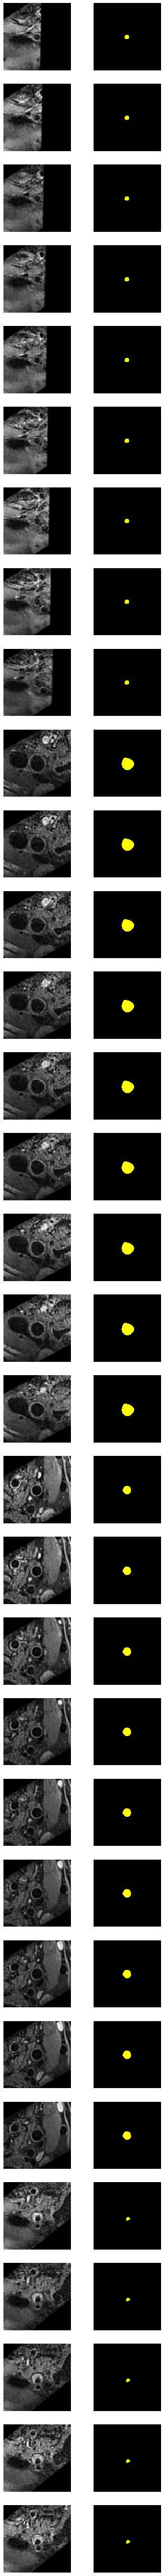

In [23]:
patient_id = train_dataset.patient_ids[8]
train_dataset.patients[patient_id].patient_plot_scans_segs()


2 32


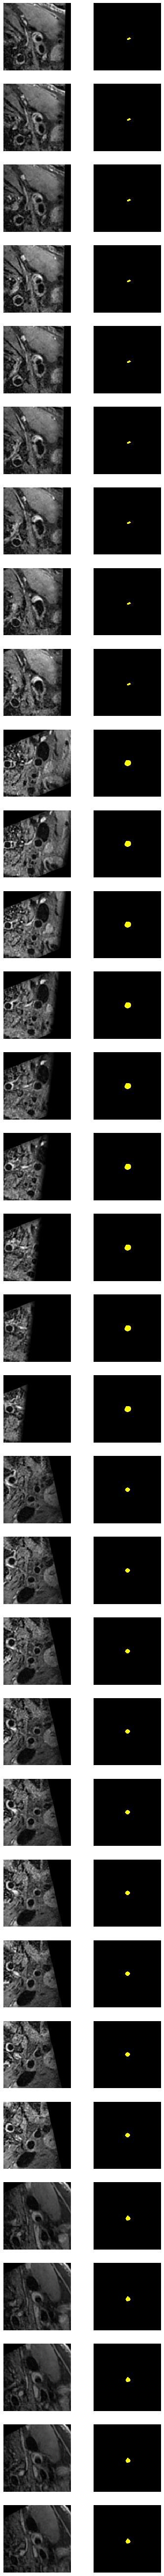

In [24]:
patient_id = eval_dataset.patient_ids[0]
eval_dataset.patients[patient_id].patient_plot_scans_segs()


2 32


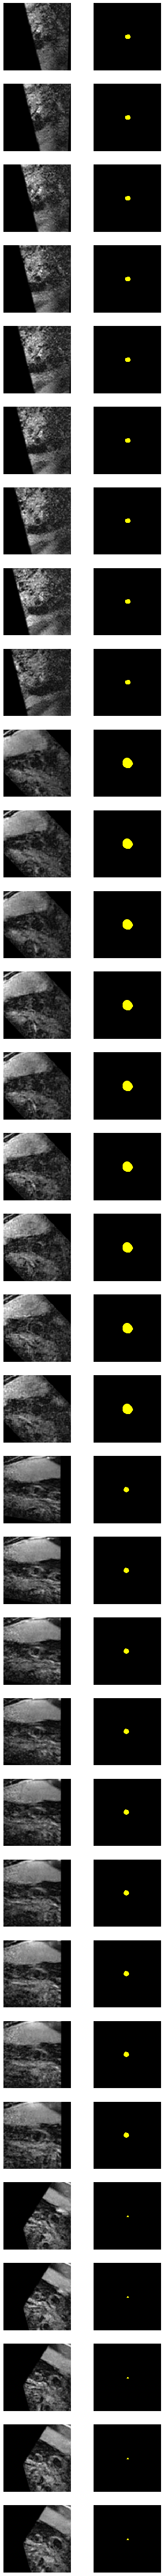

In [25]:
patient_id = test_dataset.patient_ids[0]
test_dataset.patients[patient_id].patient_plot_scans_segs()

### Anim_scan approach

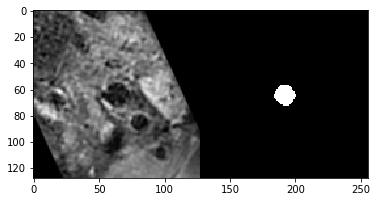

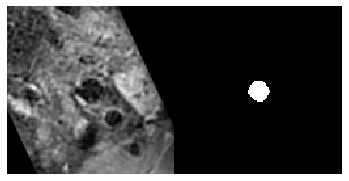

In [26]:
patient_id = train_dataset.patient_ids[0]
train_dataset.patients[patient_id].patient_anim_scans()

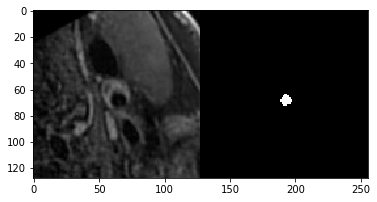

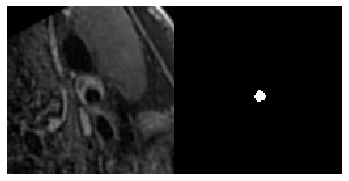

In [27]:
patient_id = eval_dataset.patient_ids[0]
eval_dataset.patients[patient_id].patient_anim_scans()

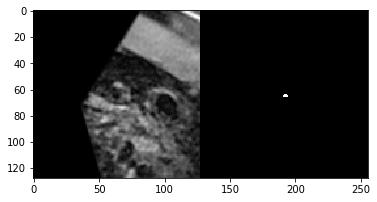

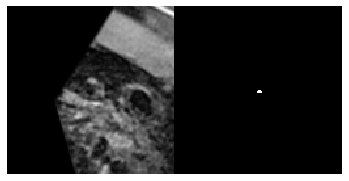

In [28]:
patient_id = test_dataset.patient_ids[0]
test_dataset.patients[patient_id].patient_anim_scans()

### Tile_scan approach

Let's check if the scans and targets still look reasonable on the previous tiled example.

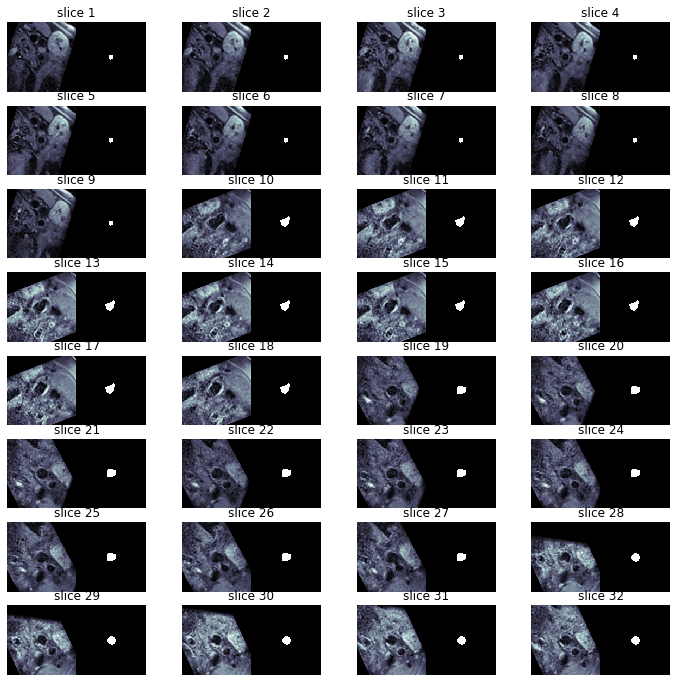

In [29]:
# note the target is now a one-hot tensor, we just show the class that we define in def tile_scans or def anim_scans
patient_id = train_dataset.patient_ids[0]
train_dataset.patients[patient_id].patient_tile_scans()

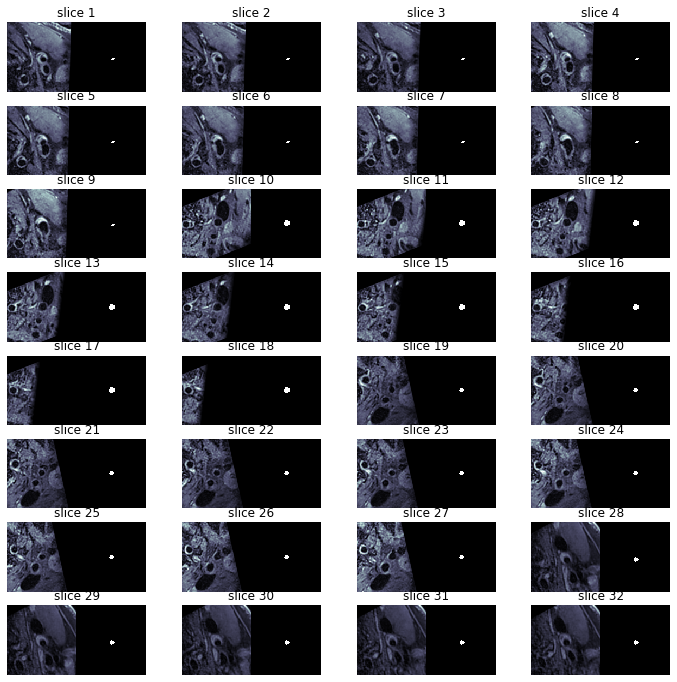

In [30]:
# note the target is now a one-hot tensor, we just show the class that we define in def tile_scans or def anim_scans
patient_id = eval_dataset.patient_ids[0]
eval_dataset.patients[patient_id].patient_tile_scans()

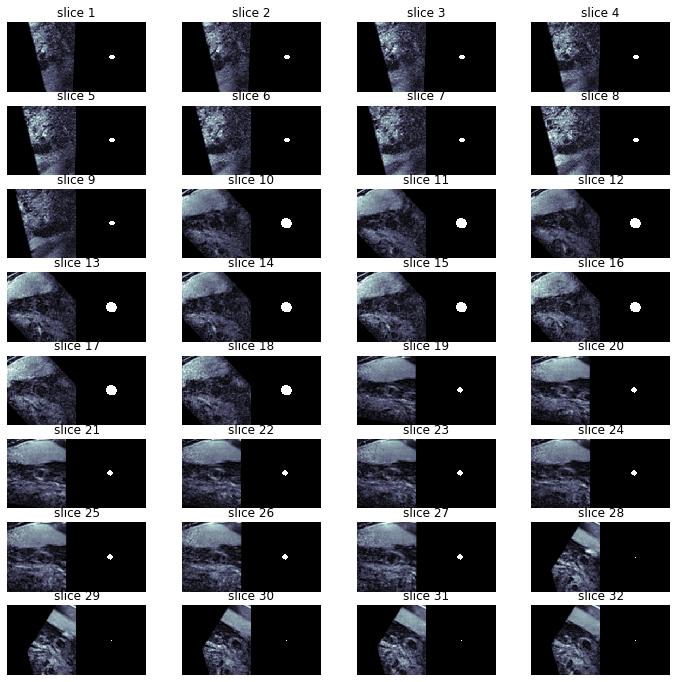

In [31]:
# note the target is now a one-hot tensor, we just show the class that we define in def tile_scans or def anim_scans
patient_id = test_dataset.patient_ids[0]
test_dataset.patients[patient_id].patient_tile_scans()

Finally, let's check that the preprocessing worked for all images. Specifically we should find that:
- the number of scans are 32 or less for all patients
- the resolution is 128 by 128 
- the maximum value of the scans is less than or equal to 1
- the corresponding target tensor has an extra dimension, corresponding to the one hot encoding of the 3 classes

In [32]:
datasets = [train_dataset, eval_dataset, test_dataset]
for dataset in datasets:
    for i in range(len(dataset.patients.keys())):
        patient_id = dataset.patient_ids[i]
        scans = dataset.patients[patient_id].scans 
        segs = dataset.patients[patient_id].segs

        assert(scans.shape[1:] == (128, 128))
        assert(scans.shape[0] <= 32)
        assert(scans.max() <= 1)
        
        assert(segs.shape[1:3] == (128, 128))
        assert(segs.shape[0] <= 32)
        assert(segs.shape[3] == 3)

print("scans.shape: ", scans.shape)
#print("scans.shape[1:]: ", scans.shape[1:])
#print("scans.shape[0]: ", scans.shape[0])
print("scans.max(): ", scans.max())

print("..................................")

print("segs.shape: ", segs.shape)
#print("segs.shape[1:3]: ", seg.shape[1:3])
#print("segs.shape[1:]: ", seg.shape[0])
#print("segs.shape[3]: ", seg.shape[3])
print("segs.max(): ", segs.max())



scans.shape:  (32, 128, 128)
scans.max():  0.9863701164722438
..................................
segs.shape:  (32, 128, 128, 3)
segs.max():  1


## Save resized datasets

We save them as pickled objects so we can use them later for training and model evaluation.

In [33]:
train_dataset.save_dataset('../data/processed/train_dataset_resized.pckl')
eval_dataset.save_dataset('../data/processed/eval_dataset_resized.pckl')
test_dataset.save_dataset('../data/processed/test_dataset_resized.pckl')